# Traffic Detection Model Training

**Objective:** Train a YOLOv8 object detection model to identify traffic objects (bicycles, buses, cars, motorbikes, pedestrians) for traffic monitoring and safety applications.

**Dataset:** Traffic Detection Project (Kaggle)
- 5,805 training images
- 549 validation images  
- 549 test images
- 5 classes: bicycle, bus, car, motorbike, person

## 1. Dataset Acquisition

Download traffic detection dataset from Kaggle using kagglehub.

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yusufberksardoan/traffic-detection-project")

print("Path to dataset files:", path)

100%|██████████| 583M/583M [00:29<00:00, 20.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/yusufberksardoan/traffic-detection-project/versions/1


## 2. Dataset Exploration

Verify dataset structure and check train/test/valid splits.

In [3]:
import os
dataset_path = path
for root, dirs, files in os.walk(dataset_path):
    level = root.replace(dataset_path, '').count(os.sep)
    indent = '  ' * level
    folder_name = os.path.basename(root)
    print(f"{indent} {folder_name}/")

    # Show folders
    subindent = '  ' * (level + 1)
    for dir_name in dirs:
        print(f"{subindent} {dir_name}/")

    # Show first 3 files
    for i, file in enumerate(files[:3]):
        print(f"{subindent} {file}")
    if len(files) > 3:
        print(f"{subindent}... and {len(files)-3} more files")

    if level > 2:
        break

 1/
   train/
   test/
   valid/
   README.dataset.txt
   README.roboflow.txt
   data.yaml
   train/
     images/
     labels/
     images/
       duque_de_caxias-1855_png_jpg.rf.424daef1888b16c20d5b8b8199b2b153.jpg
       screenshot_1639_jpg.rf.ec206ed0ad70bb94a825baa163e9f4c5.jpg
       ant_sales-2320_png_jpg.rf.a94bb9882272cdfcaffabd5dbcc54151.jpg
      ... and 5802 more files
     labels/
       image89_png_jpg.rf.8d406b589b39f430b31bbdf933013def.txt
       ant_sales-2105_png_jpg.rf.de2bac550d3648ca1daebb94fd396035.txt
       aguanambi-4715_png_jpg.rf.19728e63ad5073f56d3d1ebe3e7981be.txt
      ... and 5802 more files
   test/
     images/
     labels/
     images/
       ant_sales-1045_png_jpg.rf.a4819b54dede09cef62664156b2e767b.jpg
       duque_de_caxias-1460_png_jpg.rf.6f3adf09f585ad269e88f737da6f9192.jpg
       aguanambi-3565_png_jpg.rf.a8e3ff61869acbaab7d4554782ef6c0b.jpg
      ... and 276 more files
     labels/
       screenshot_10434_jpg.rf.f883516c2fe87b81610b5b72603c4c78.t

In [4]:
!mkdir -p /content/data
# Copy data to a working directory
!cp -r {dataset_path}/* /content/data/

# Verify copy
!ls -la /content/data/

total 32
drwxr-xr-x 5 root root 4096 Nov 24 20:45 .
drwxr-xr-x 1 root root 4096 Nov 24 20:44 ..
-rw-r--r-- 1 root root  291 Nov 24 20:45 data.yaml
-rw-r--r-- 1 root root  137 Nov 24 20:45 README.dataset.txt
-rw-r--r-- 1 root root 1219 Nov 24 20:45 README.roboflow.txt
drwxr-xr-x 4 root root 4096 Nov 24 20:45 test
drwxr-xr-x 4 root root 4096 Nov 24 20:45 train
drwxr-xr-x 4 root root 4096 Nov 24 20:45 valid


## 3. Environment Setup

Install YOLOv8 and verify GPU availability for faster training.

**Why YOLOv8?**
- State of the art in real-time object detection
- Excellent balance of speed and accuracy
- Easy fine-tuning with custom datasets

In [5]:
!pip install ultralytics -q
import torch
from ultralytics import YOLO
if torch.cuda.is_available():
    device = 0
else:
    device = 'cpu'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 72.5 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## 4. Configure Data Paths

Update data.yaml with absolute paths for Colab environment.

In [6]:
import yaml
from pathlib import Path

# Read the original data.yaml
data_root = Path(path)
yaml_file = data_root / "data.yaml"

with open(yaml_file, 'r') as f:
    config = yaml.safe_load(f)

# Update with absolute paths
config['train'] = str(data_root / 'train' / 'images')
config['val'] = str(data_root / 'valid' / 'images')
config['test'] = str(data_root / 'test' / 'images')

# Save to /content/ (writable location)
updated_yaml = '/content/data_colab.yaml'
with open(updated_yaml, 'w') as f:
    yaml.dump(config, f)

print("Data configuration created!")
print(f"Number of classes: {config['nc']}")
print(f"Class names: {config['names']}")
print(f"Updated paths:")
print(f"Train: {config['train']}")
print(f"Val: {config['val']}")
print(f"Test: {config['test']}")

Data configuration created!
Number of classes: 5
Class names: ['bicycle', 'bus', 'car', 'motorbike', 'person']
Updated paths:
Train: /root/.cache/kagglehub/datasets/yusufberksardoan/traffic-detection-project/versions/1/train/images
Val: /root/.cache/kagglehub/datasets/yusufberksardoan/traffic-detection-project/versions/1/valid/images
Test: /root/.cache/kagglehub/datasets/yusufberksardoan/traffic-detection-project/versions/1/test/images


**Train the model**

Train YOLOv8 nano model on Tesla T4 GPU with early stopping

In [7]:
# Load YOLOv8 nano
model = YOLO('yolov8n.pt')

# Train
results = model.train(
    data='/content/data_colab.yaml',
    epochs=10,
    imgsz=640,
    batch=8,
    device=device,
    project='/content/models',
    name='traffic_detection',
    patience=10,
    save=True,
    plots=True,
    verbose=True,
    cache=True
)

Ultralytics 8.3.231 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data_colab.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=traffic_detection, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=True, pose

## 6. Training Results

Visualize training curves and confusion matrix to evaluate performance.
## Visualizations

**Results Plot:** Training progress showing loss reduction, precision/recall improvement, and mAP50 reaching 0.89 over 10 epochs.

**Confusion Matrix:** Per-class accuracy heatmap. Strong diagonal indicates good predictions. Model excels at car detection, moderate performance on detecting pedestrians.

Found: results.png
Found: confusion_matrix.png
Missing: F1_curve.png
Missing: PR_curve.png


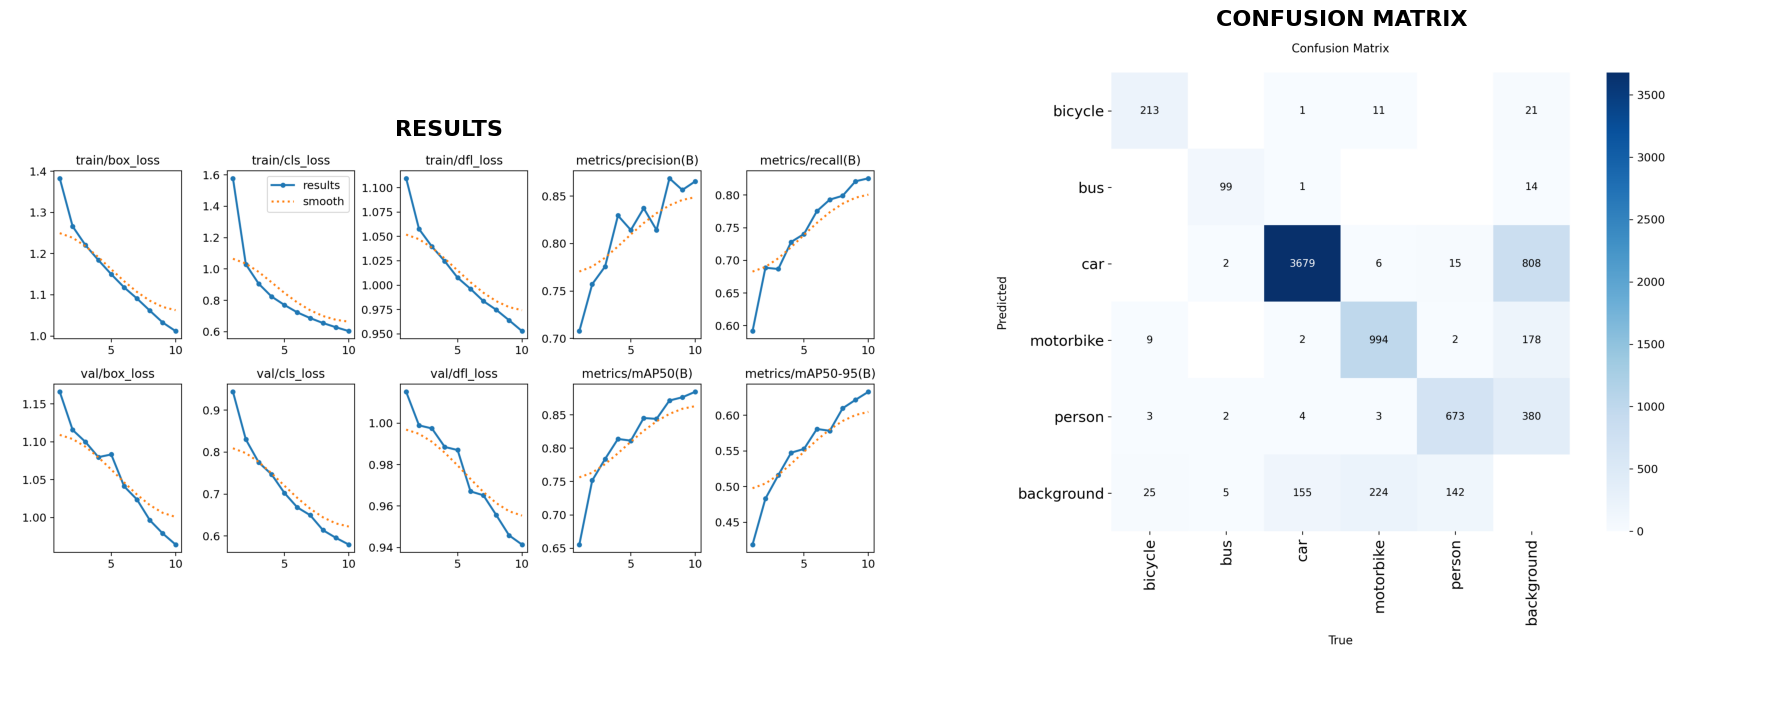

 Displayed 2 visualization(s)
Saved to: /content/training_summary.png


In [12]:
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

model_dir = Path("/content/models/traffic_detection")

# List of possible plots
plot_names = ['results.png', 'confusion_matrix.png', 'F1_curve.png', 'PR_curve.png']

# Check which plots actually exist
available_plots = []
for plot_name in plot_names:
    plot_path = model_dir / plot_name
    if plot_path.exists():
        available_plots.append(plot_name)
        print(f"Found: {plot_name}")
    else:
        print(f"Missing: {plot_name}")

# Only display plots that exist
if available_plots:
    # Calculate grid size based on available plots
    num_plots = len(available_plots)

    if num_plots == 1:
        fig, axes = plt.subplots(1, 1, figsize=(16, 12))
        axes = [axes]
    elif num_plots == 2:
        fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    else:
        cols = 2
        rows = (num_plots + 1) // 2
        fig, axes = plt.subplots(rows, cols, figsize=(18, 8 * rows))
        axes = axes.flatten()

    # Display each available plot
    for idx, plot_name in enumerate(available_plots):
        plot_path = model_dir / plot_name
        img = Image.open(plot_path)
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(
            plot_name.replace('.png', '').replace('_', ' ').upper(),
            fontsize=16,
            fontweight='bold'
        )

    # Hide any unused subplots
    if num_plots > 1:
        for idx in range(num_plots, len(axes)):
            axes[idx].axis('off')

    plt.tight_layout()
    plt.savefig('/content/training_summary.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f" Displayed {num_plots} visualization(s)")
    print("Saved to: /content/training_summary.png")
else:
    print(" No visualization plots found")

## 7. Model Testing

Test trained model on sample images to verify detection accuracy.

Model loaded from: /content/models/traffic_detection/weights/best.pt

Found 5 test images


image 1/1 /root/.cache/kagglehub/datasets/yusufberksardoan/traffic-detection-project/versions/1/test/images/ant_sales-1045_png_jpg.rf.a4819b54dede09cef62664156b2e767b.jpg: 640x640 1 bus, 4 cars, 1 motorbike, 7.4ms
Speed: 16.8ms preprocess, 7.4ms inference, 11.5ms postprocess per image at shape (1, 3, 640, 640)


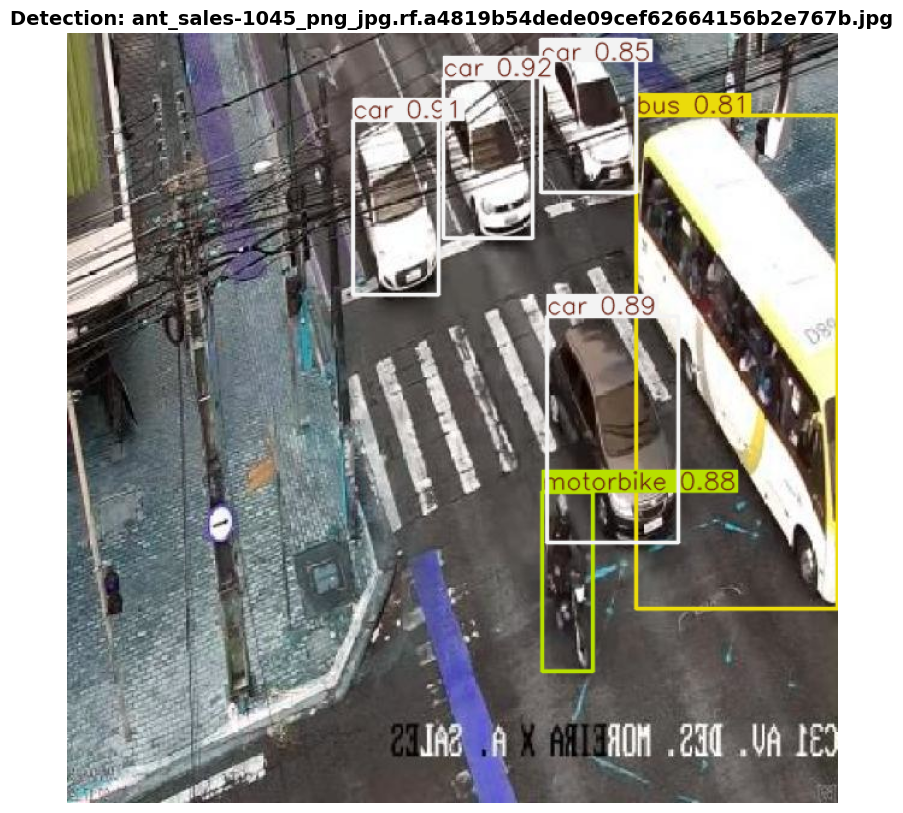

ant_sales-1045_png_jpg.rf.a4819b54dede09cef62664156b2e767b.jpg: Detected 6 objects
  - Class: car, Confidence: 0.92
  - Class: car, Confidence: 0.91
  - Class: car, Confidence: 0.89
  - Class: motorbike, Confidence: 0.88
  - Class: car, Confidence: 0.85
  - Class: bus, Confidence: 0.81

image 1/1 /root/.cache/kagglehub/datasets/yusufberksardoan/traffic-detection-project/versions/1/test/images/duque_de_caxias-1460_png_jpg.rf.6f3adf09f585ad269e88f737da6f9192.jpg: 640x640 2 bicycles, 2 buss, 7 cars, 12 motorbikes, 11.0ms
Speed: 2.1ms preprocess, 11.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


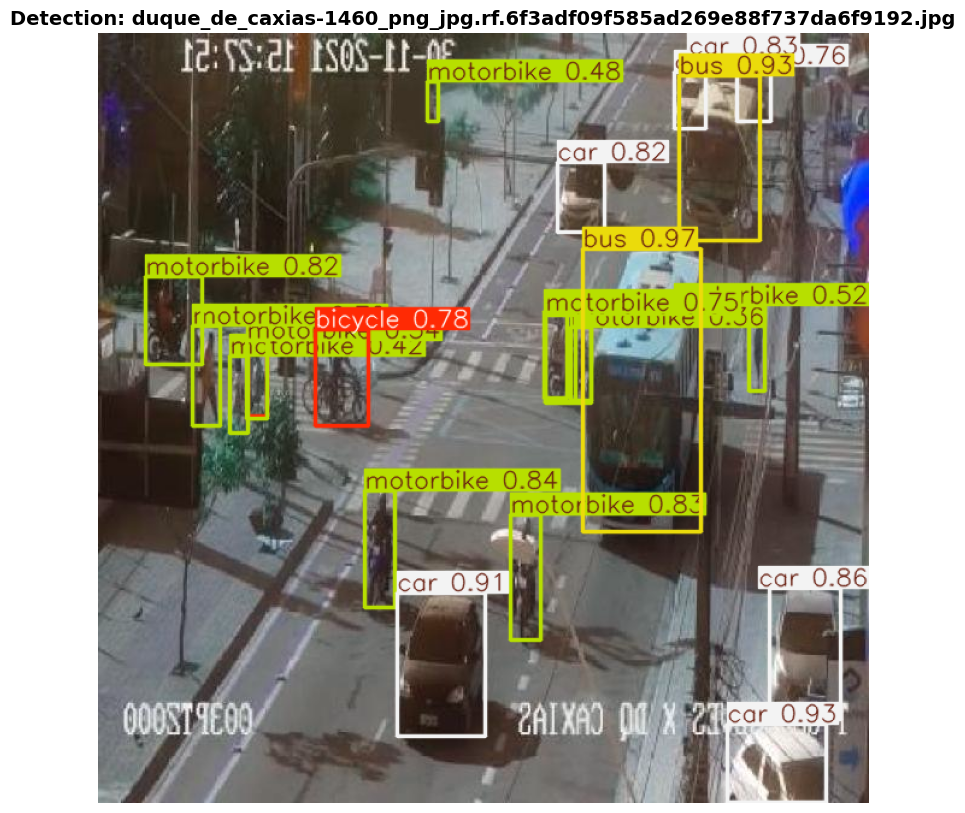

duque_de_caxias-1460_png_jpg.rf.6f3adf09f585ad269e88f737da6f9192.jpg: Detected 23 objects
  - Class: bus, Confidence: 0.97
  - Class: bus, Confidence: 0.93
  - Class: car, Confidence: 0.93
  - Class: car, Confidence: 0.91
  - Class: car, Confidence: 0.86
  - Class: motorbike, Confidence: 0.84
  - Class: motorbike, Confidence: 0.83
  - Class: car, Confidence: 0.83
  - Class: motorbike, Confidence: 0.82
  - Class: car, Confidence: 0.82
  - Class: bicycle, Confidence: 0.78
  - Class: car, Confidence: 0.76
  - Class: motorbike, Confidence: 0.75
  - Class: car, Confidence: 0.74
  - Class: motorbike, Confidence: 0.72
  - Class: motorbike, Confidence: 0.57
  - Class: motorbike, Confidence: 0.54
  - Class: motorbike, Confidence: 0.52
  - Class: motorbike, Confidence: 0.48
  - Class: motorbike, Confidence: 0.42
  - Class: motorbike, Confidence: 0.36
  - Class: motorbike, Confidence: 0.29
  - Class: bicycle, Confidence: 0.27

image 1/1 /root/.cache/kagglehub/datasets/yusufberksardoan/traffic-det

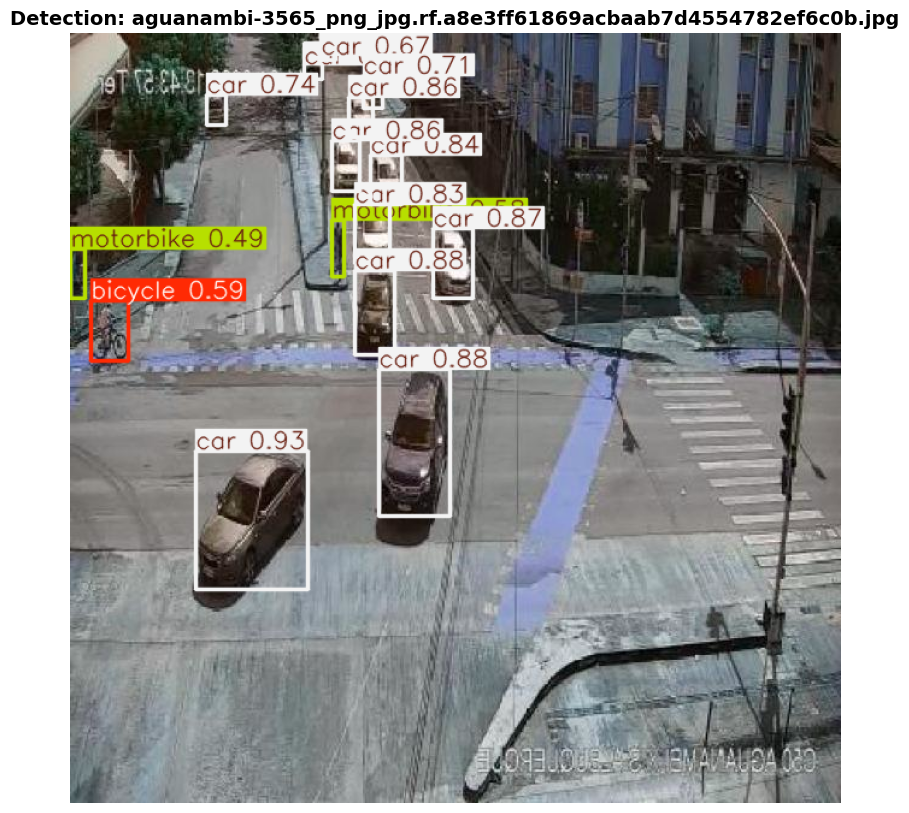

aguanambi-3565_png_jpg.rf.a8e3ff61869acbaab7d4554782ef6c0b.jpg: Detected 15 objects
  - Class: car, Confidence: 0.93
  - Class: car, Confidence: 0.88
  - Class: car, Confidence: 0.88
  - Class: car, Confidence: 0.87
  - Class: car, Confidence: 0.86
  - Class: car, Confidence: 0.86
  - Class: car, Confidence: 0.84
  - Class: car, Confidence: 0.83
  - Class: car, Confidence: 0.74
  - Class: car, Confidence: 0.71
  - Class: car, Confidence: 0.67
  - Class: bicycle, Confidence: 0.59
  - Class: motorbike, Confidence: 0.58
  - Class: car, Confidence: 0.56
  - Class: motorbike, Confidence: 0.49

image 1/1 /root/.cache/kagglehub/datasets/yusufberksardoan/traffic-detection-project/versions/1/test/images/screenshot_10136_jpg.rf.95227b3b5cecb4bfda99f05fe5ea1567.jpg: 640x640 1 bicycle, 6 cars, 11.9ms
Speed: 2.0ms preprocess, 11.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


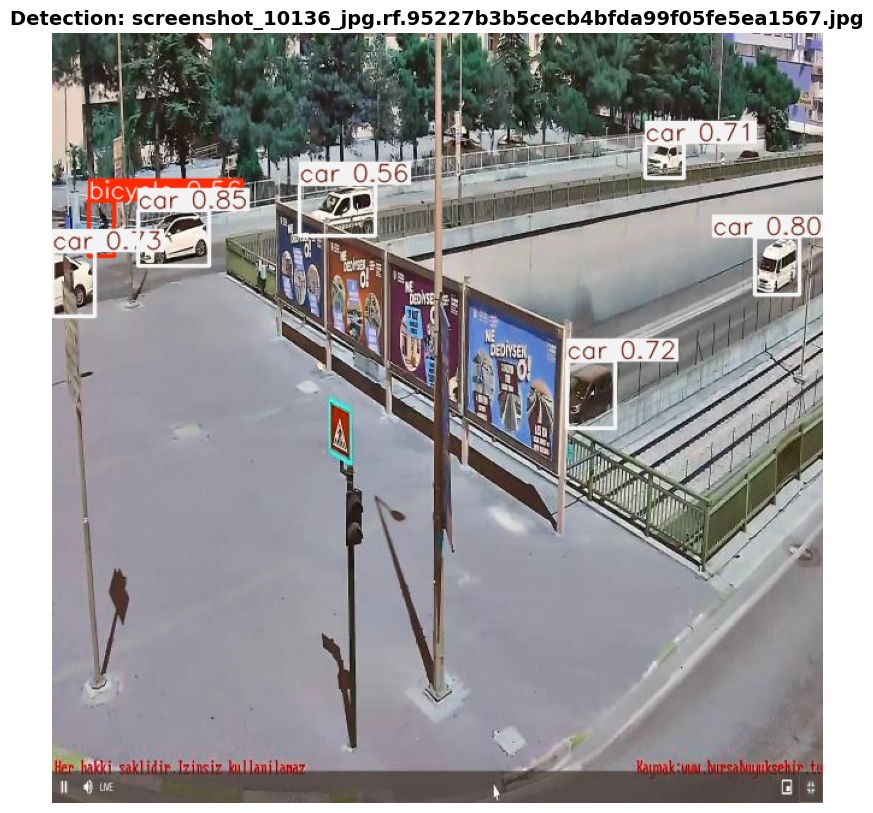

screenshot_10136_jpg.rf.95227b3b5cecb4bfda99f05fe5ea1567.jpg: Detected 7 objects
  - Class: car, Confidence: 0.85
  - Class: car, Confidence: 0.80
  - Class: car, Confidence: 0.73
  - Class: car, Confidence: 0.72
  - Class: car, Confidence: 0.71
  - Class: bicycle, Confidence: 0.56
  - Class: car, Confidence: 0.56

image 1/1 /root/.cache/kagglehub/datasets/yusufberksardoan/traffic-detection-project/versions/1/test/images/screenshot_11030_jpg.rf.74c2874cac4916f2e472aeb6437bd2ec.jpg: 640x640 7 cars, 9.9ms
Speed: 2.5ms preprocess, 9.9ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


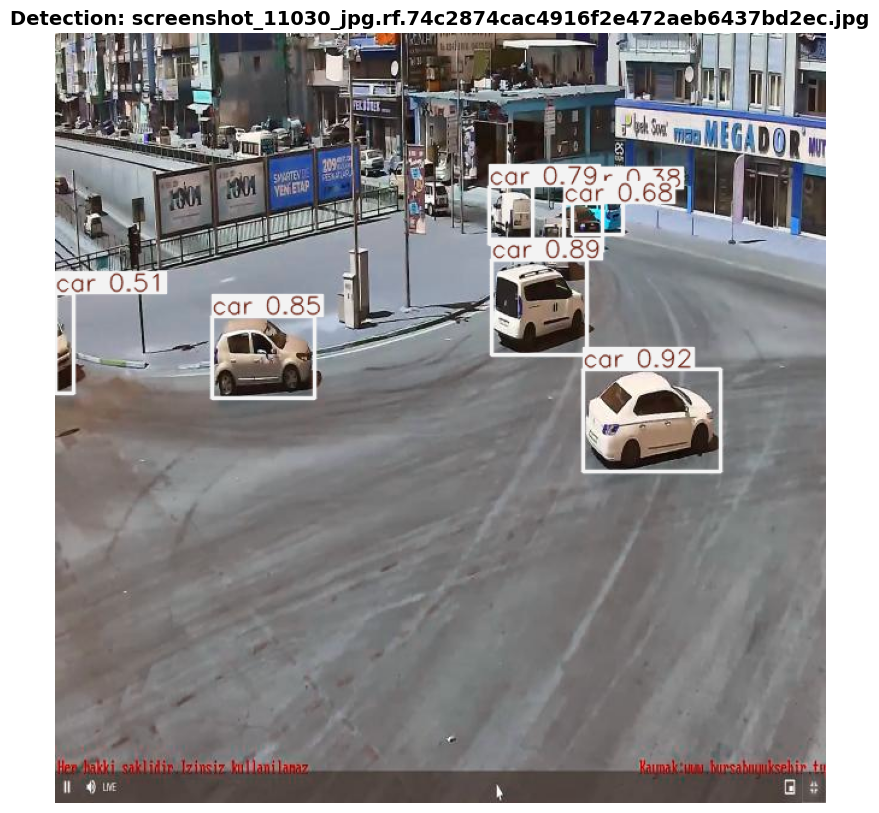

screenshot_11030_jpg.rf.74c2874cac4916f2e472aeb6437bd2ec.jpg: Detected 7 objects
  - Class: car, Confidence: 0.92
  - Class: car, Confidence: 0.89
  - Class: car, Confidence: 0.85
  - Class: car, Confidence: 0.79
  - Class: car, Confidence: 0.68
  - Class: car, Confidence: 0.51
  - Class: car, Confidence: 0.38


In [14]:
from ultralytics import YOLO
import glob

# Load your trained model
model_path = "/content/models/traffic_detection/weights/best.pt"
best_model = YOLO(model_path)

print(f"Model loaded from: {model_path}\n")

# Get test images (using the path variable from earlier)
test_images = glob.glob(f'{path}/test/images/*.jpg')[:5]

if not test_images:
    test_images = glob.glob(f'{path}/test/images/*.png')[:5]

print(f"Found {len(test_images)} test images\n")

for img_path in test_images:
    # Predict
    results = best_model.predict(
        source=img_path,
        conf=0.25,
        save=False
    )

    # Display
    plt.figure(figsize=(14, 10))
    plt.imshow(results[0].plot())
    plt.axis('off')
    plt.title(f"Detection: {Path(img_path).name}", fontsize=14, fontweight='bold')
    plt.show()

    # Show what was detected
    boxes = results[0].boxes
    print(f"{Path(img_path).name}: Detected {len(boxes)} objects")
    for box in boxes:
        cls = int(box.cls[0])
        conf = float(box.conf[0])
        print(f"  - Class: {results[0].names[cls]}, Confidence: {conf:.2f}")

## 8. Export Model

Package trained model and visualizations for deployment.

In [16]:
# Zip all important files
!zip -r /content/traffic_model_complete.zip \
    /content/models/traffic_detection/weights/best.pt \
    /content/models/traffic_detection/weights/last.pt \
    /content/models/traffic_detection/*.png \
    /content/models/traffic_detection/*.csv \
    /content/training_summary.png 2>/dev/null


# Download
from google.colab import files
files.download('/content/traffic_model_complete.zip')

updating: content/models/traffic_detection/weights/best.pt (deflated 9%)
updating: content/models/traffic_detection/weights/last.pt (deflated 9%)
updating: content/models/traffic_detection/BoxF1_curve.png (deflated 7%)
updating: content/models/traffic_detection/BoxP_curve.png (deflated 8%)
updating: content/models/traffic_detection/BoxPR_curve.png (deflated 9%)
updating: content/models/traffic_detection/BoxR_curve.png (deflated 8%)
updating: content/models/traffic_detection/confusion_matrix_normalized.png (deflated 22%)
updating: content/models/traffic_detection/confusion_matrix.png (deflated 23%)
updating: content/models/traffic_detection/results.png (deflated 7%)
updating: content/models/traffic_detection/results.csv (deflated 58%)
updating: content/training_summary.png (deflated 9%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>